# cand_trial006


In [1]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
from tqdm import tqdm
import multiprocessing
import inspect

import pandas as pd
import numpy as np
import itertools
import cudf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import line_notify
import my_logger
from noglobal import noglobal
import optuna

# 設定

In [2]:
@dataclass
class Cfg:
    loglevel = "INFO"
    exp_name = "cand_trial006"
    seed = 42
    k = 20
    cand_n = 15
    type2id = {"clicks":0, "carts":1, "orders":2}
    id2type = {0:"clicks", 1:"carts", 2:"orders"}
    train_weeks = ["week3"]
    valid_week = "week3"
    valid_session_n = 100_000
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")

cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)
random.seed(cfg.seed)

In [3]:
class Cache:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self):
        self.cache_dir = (os.path.join(cfg.output_dir, cfg.exp_name, "cache"))
        self.cache_dir_path = pathlib.Path(self.cache_dir)
        self.caches = list(self.cache_dir_path.glob("*.pkl"))

    @noglobal(excepts=["cfg", "logger"])
    def get_abspath(self, filename):
        return (os.path.join(self.cache_dir, f"{cfg.exp_name}_{filename}"))
    
    @noglobal(excepts=["cfg", "logger"])
    def exists(self, path):
        return len([str(c) for c in self.caches if path == str(c)]) > 0

In [4]:
logger = my_logger.init_logger(cfg.exp_name)
cache = Cache()

In [5]:
@noglobal(excepts=["cfg", "logger"])
def evaluate(clicks_labels, carts_labels, orders_labels, 
             clicks_preds, carts_preds, orders_preds, k=20):

    num_clicks = 0
    num_carts = 0
    num_orders = 0
    hit_clicks = 0
    hit_carts = 0
    hit_orders = 0

    for i in range(len(clicks_labels)):
        clicks_label = clicks_labels[i]
        carts_label = carts_labels[i]
        orders_label = orders_labels[i]
        clicks_pred = clicks_preds[i]
        carts_pred = carts_preds[i]
        orders_pred = orders_preds[i]

        if type(clicks_pred) == list:
            clicks_pred = clicks_pred[:k]
        else:
            clicks_pred = []
        if type(carts_pred) == list:
            carts_pred = carts_pred[:k]
        else:
            carts_pred = []    
        if type(orders_pred) == list:
            orders_pred = orders_pred[:k]
        else:
            orders_pred = []

        if not np.isnan(clicks_label):
            num_clicks += 1
            hit_clicks += int(clicks_label in clicks_pred)

        if type(carts_label) == list:
            num_carts += min(len(carts_label), k)
            hit_carts += len(set(carts_pred) & set(carts_label))
            
        if type(orders_label) == list:
            num_orders += min(len(orders_label), k)
            hit_orders += len(set(orders_pred) & set(orders_label))


    recall_clicks = hit_clicks / num_clicks
    recall_carts = hit_carts / num_carts
    recall_orders = hit_orders / num_orders
    w_recall_clicks = recall_clicks * 0.10
    w_recall_carts = recall_carts * 0.30
    w_recall_orders = recall_orders * 0.60
    score = w_recall_clicks + w_recall_carts + w_recall_orders

    results = {}
    results["num_clicks"] = num_clicks
    results["hit_clicks"] = hit_clicks
    results["num_carts"] = num_carts
    results["hit_carts"] = hit_carts
    results["num_orders"] = num_orders
    results["hit_orders"] = hit_orders
    results["recall_clicks"] = format(recall_clicks, ".3f")
    results["recall_carts"] = format(recall_carts, ".3f")
    results["recall_orders"] = format(recall_orders, ".3f")
    results["w_recall_clicks"] = format(w_recall_clicks, ".3f")
    results["w_recall_carts"] = format(w_recall_carts, ".3f")
    results["w_recall_orders"] = format(w_recall_orders, ".3f")
    results["score"] = format(score, ".3f")

    return results

In [6]:
class Candidate:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, pdf, week, labels=None):
        self.df = cudf.from_pandas(pdf)
        self.target_sessions = pdf["session"].unique().tolist()
        self.results = pd.DataFrame(columns=["name", "num_clicks", "hit_clicks", "num_carts", "hit_carts", "num_orders", "hit_orders", 
                                             "recall_clicks", "recall_carts", "recall_orders", "w_recall_clicks", "w_recall_carts", "w_recall_orders", "score"])
        self.output = pd.DataFrame(columns=["session", "aid"], dtype=int)
        self.labels = labels
        self.week = week
    
    @noglobal(excepts=["cfg", "logger"])
    def _entry(self, new_candidate_df, name, k):
        logger.info(f"[add_candidate] {name} : start")
        new_candidate_df = new_candidate_df.to_pandas()
        self.output = pd.concat([self.output, new_candidate_df[["session", "aid"]]])
        self.output = self.output.drop_duplicates(subset=["session", "aid"])

        if self.labels is not None:
            self._eval(new_candidate_df[["session", "aid"]], name, k)
    
    @noglobal(excepts=["cfg", "logger"])
    def _eval(self, new_candidate_df, name, k):
        new_candidate_df = new_candidate_df.groupby("session")["aid"].apply(list).reset_index()
        eval_df = pd.DataFrame(self.target_sessions, columns=["session"])
        eval_df = eval_df.merge(new_candidate_df, on=["session"], how="left")
        assert eval_df["session"].tolist() == self.labels["session"].tolist()
        eval_result = evaluate(self.labels["clicks_labels"].tolist(), self.labels["carts_labels"].tolist(), self.labels["orders_labels"].tolist(),
                               eval_df["aid"].tolist(), eval_df["aid"].tolist(), eval_df["aid"].tolist(), k)
        
        logger.info(name)
        logger.info(eval_result)
        self.results = pd.concat([self.results, pd.DataFrame([[name] + list(eval_result.values())], columns=["name"] + list(eval_result.keys()))])

    @noglobal(excepts=["cfg", "logger"])
    def add(self, strategy, name, usetypes=['clicks', 'carts', 'orders'], trans_map=None, k=20):
        logger.info(f"[make_candidate] {name} : start")
        candidate_df = self.df[self.df["type"].isin(usetypes)].copy()
        
        if strategy == "session_frequent":
            candidate_df = self._session_frequent(candidate_df, k)
        elif strategy == "session_latest":
            candidate_df = self._session_latest(candidate_df, k)
        elif strategy == "total_frequent":
            candidate_df = self._total_frequent(candidate_df, k)
        elif strategy == "w2v_session_total_aid_vec_sim":
            candidate_df = self._w2v_session_total_aid_vec_sim()
        elif strategy == "w2v_session_carts_total_aid_vec_sim":
            candidate_df = self._w2v_session_carts_total_aid_vec_sim()
        
        if trans_map is not None:
            candidate_df["aid"] = candidate_df["aid"].map(trans_map)
            candidate_df = candidate_df.dropna(subset=["aid"])
            
        self._entry(candidate_df, name, k)

    @noglobal(excepts=["cfg", "logger"])
    def _session_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby(["session", "aid"])["ts"].count().reset_index()
        candidate_df.columns = ["session", "aid", "aid_count"]
        candidate_df = candidate_df.sort_values(["session", "aid_count", "aid"], ascending=(True, False, True))
        candidate_df = candidate_df[candidate_df.groupby("session")["aid_count"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _session_latest(self, candidate_df, k):
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False)).drop_duplicates(subset=["session", "aid"])
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False))[candidate_df.groupby("session")["ts"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _total_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby("aid")["ts"].count().reset_index()
        candidate_df.columns = ["aid", "aid_count"]
        topk_freq_aids = candidate_df.sort_values("aid_count", ascending=False)["aid"].to_arrow().to_pylist()[:k]
        sessions = []
        aids = []
        for session, aid in itertools.product(self.target_sessions, topk_freq_aids):
            sessions.append(session)
            aids.append(aid)
        candidate_df = cudf.DataFrame({"session": sessions, "aid": aids})
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _w2v_session_total_aid_vec_sim(self):
        if self.week is not None:
            candidate_df = pd.read_pickle(cfg.prep_dir + f"w2v_session_total_avg_similar_aids_{self.week}.pkl")
        else:
            candidate_df = pd.read_pickle(cfg.prep_dir + "w2v_session_total_avg_similar_aids.pkl")
        candidate_df = cudf.from_pandas(candidate_df)
        candidate_df = candidate_df[["session", "aid"]].copy()
        candidate_df = candidate_df[candidate_df["session"].isin(self.target_sessions)]
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _w2v_session_carts_total_aid_vec_sim(self):
        if self.week is not None:
            candidate_df = pd.read_pickle(cfg.prep_dir + f"w2v_session_carts_total_avg_similar_aids_{self.week}.pkl")
        else:
            candidate_df = pd.read_pickle(cfg.prep_dir + "w2v_session_carts_total_avg_similar_aids.pkl")
        candidate_df = cudf.from_pandas(candidate_df)
        candidate_df = candidate_df[["session", "aid"]].copy()
        candidate_df = candidate_df[candidate_df["session"].isin(self.target_sessions)]
        return candidate_df

In [7]:
@noglobal(excepts=["cfg", "logger"])
def make_cand_df(sessions, week, labels=None, trans_maps=None):

    if labels is not None:
         cand = Candidate(sessions, week, labels)
    else:
        cand = Candidate(sessions, week)

    cand.add(strategy="session_frequent", name="session_frequent", k=15)
    cand.add(strategy="session_latest", name="session_latest", k=15)
    cand.add(strategy="w2v_session_total_aid_vec_sim", name="w2v_session_total_aid_vec_sim")
    cand.add(strategy="w2v_session_carts_total_aid_vec_sim", name="w2v_session_carts_total_aid_vec_sim")
    
    for i in range(20):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"time_wt_pair{str(i)}"], name=f"session_latest_time_wt_pair{str(i)}", k=5)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"word2vec_pair{str(i)}"], name=f"session_latest_word2vec_pair{str(i)}", k=5)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"pair{str(i)}"], name=f"session_latest_pair{str(i)}", k=5)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"type_wt_pair{str(i)}"], name=f"session_latest_type_wt_pair{str(i)}", k=5)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"clicks2carts_pair{str(i)}"], name=f"session_latest_clicks2carts_pair{str(i)}", k=5)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"clicks2orders_pair{str(i)}"], name=f"session_latest_clicks2orders_pair{str(i)}", k=5)

    if labels is not None:
        return cand.output, cand.results
    else:
        return cand.output

In [8]:
@noglobal(excepts=["cfg", "logger"])
def get_pair_df(name, wt_col, week):
    if week is not None:
        name = f"{name}_{week}"
    pair_df = pd.read_pickle(cfg.prep_dir + f"{name}.pkl")
    pair_df = pair_df.sort_values(["aid_x", wt_col], ascending=(True, False))
    return pair_df

@noglobal(excepts=["cfg", "logger"])
def get_pair_dict(name, wt_col, week):
    if week is not None:
        name = f"{name}_{week}"
    pair_df = pd.read_pickle(cfg.prep_dir + f"{name}.pkl")
    pair_df = pair_df.sort_values(["aid_x", wt_col], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    return pair_dict

@noglobal(excepts=["cfg", "logger"])
def get_trans_maps(week=None):
    """
    aidを別のaidに置き換えるmapping辞書を取得する
    """
    trans_maps = {}
    
    pair_df_org = get_pair_df("co_visitation_matrix", "cnt", week)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"pair{str(i)}"] = pair_dict
    
    pair_df_org = get_pair_df("co_visitation_matrix_time_weighted", "wt", week)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"time_wt_pair{str(i)}"] = pair_dict

    pair_df_org = get_pair_df("co_visitation_matrix_type_weighted", "wt", week)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"type_wt_pair{str(i)}"] = pair_dict

    pair_df_org = get_pair_df("co_visitation_matrix_clicks2carts", "cnt", week)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"clicks2carts_pair{str(i)}"] = pair_dict

    pair_df_org = get_pair_df("co_visitation_matrix_clicks2orders", "cnt", week)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"clicks2orders_pair{str(i)}"] = pair_dict

    pair_df_org = get_pair_df("word2vec_similar", "sim", None)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"word2vec_pair{str(i)}"] = pair_dict

    with open(cfg.prep_dir + "matrix_factorization_embeddings_similar_top20.pkl", "rb") as f:
        nns = pickle.load(f)
    for i in range(20):
        pair_dict = {aid_x:aid_ys[i] for aid_x, aid_ys in enumerate(nns)}
        trans_maps[f"matrix_fact_pair{str(i)}"] = pair_dict

    return trans_maps

In [9]:
@noglobal(excepts=["cfg", "logger"])
def make_valid_data(trans_maps):
    valid_week = cfg.valid_week
    dfs = []
    
    logger.info(f"[make_valid] valid_week : {valid_week}")
    # データ読み込み
    logger.info("[make_valid] read_data : start")
    week_sessions = pd.read_pickle(os.getenv("PREP_DIR") + f"train_sessions_{valid_week}.pkl")
    week_labels = pd.read_pickle(os.getenv("PREP_DIR") + f"labels_{valid_week}.pkl")
    valid_session_ids = week_sessions["session"].unique().tolist()
    logger.info("[make_valid] read_data : end")

    # validに使うsessionを絞る (trainに存在するsessionを除外した上で設定した数に絞る)
    logger.info("[make_valid] valid_session_extract : start")
    valid_session_n = min(cfg.valid_session_n, len(valid_session_ids))
    valid_session_ids = random.sample(valid_session_ids, valid_session_n)
    week_sessions = week_sessions[week_sessions["session"].isin(valid_session_ids)].copy()
    week_labels = week_labels[week_labels["session"].isin(valid_session_ids)].copy()
    logger.info("[make_valid] valid_session_extract : end")

    # 候補選出
    logger.info("[make_valid] make_cand_df : start")
    valid, results = make_cand_df(week_sessions, valid_week, labels=week_labels, trans_maps=trans_maps)

    return valid, week_labels, results

In [10]:
logger.info("\n\nSTART\n\n")
cache_file = f"trans_maps.pkl"
cache_path = cache.get_abspath(cache_file)

if cache.exists(cache_path):
    logger.info(f"[{cache_file}] cache exists. load cache and skip process.")
    with open(cache_path, "rb") as f:
        trans_maps = pickle.load(f)
else:
    trans_maps = get_trans_maps("week4")
    with open(cache_path, "wb") as f:
        pickle.dump(trans_maps, f)

valid, valid_labels, results = make_valid_data(trans_maps)

0:00:00.303478 	 

START


0:41:03.684112 	 [make_valid] valid_week : week3
0:41:03.707862 	 [make_valid] read_data : start
0:41:13.928634 	 [make_valid] read_data : end
0:41:13.929715 	 [make_valid] valid_session_extract : start
0:41:14.999710 	 [make_valid] valid_session_extract : end
0:41:15.001248 	 [make_valid] make_cand_df : start
0:41:15.106235 	 [make_candidate] session_frequent : start
0:41:15.469212 	 [add_candidate] session_frequent : start
0:41:17.083679 	 session_frequent
0:41:17.084912 	 {'num_clicks': 97259, 'hit_clicks': 28853, 'num_carts': 40687, 'hit_carts': 10215, 'num_orders': 19728, 'hit_orders': 9987, 'recall_clicks': '0.297', 'recall_carts': '0.251', 'recall_orders': '0.506', 'w_recall_clicks': '0.030', 'w_recall_carts': '0.075', 'w_recall_orders': '0.304', 'score': '0.409'}
0:41:17.099700 	 [make_candidate] session_latest : start
0:41:17.309635 	 [add_candidate] session_latest : start
0:41:19.112269 	 session_latest
0:41:19.113719 	 {'num_clicks': 97259, 'hit_cl

In [11]:
results

,name,num_clicks,hit_clicks,num_carts,hit_carts,num_orders,hit_orders,recall_clicks,recall_carts,recall_orders,w_recall_clicks,w_recall_carts,w_recall_orders,score
0,session_frequent,97259,28853,40687,10215,19728,9987,0.297,0.251,0.506,0.030,0.075,0.304,0.409
0,session_latest,97259,29069,40687,10280,19728,9669,0.299,0.253,0.490,0.030,0.076,0.294,0.400
0,w2v_session_total_aid_vec_sim,97259,33501,41074,8529,19811,5749,0.344,0.208,0.290,0.034,0.062,0.174,0.271
0,w2v_session_carts_total_aid_vec_sim,97259,4565,41074,3028,19811,5018,0.047,0.074,0.253,0.005,0.022,0.152,0.179
0,session_latest_time_wt_pair0,97259,8705,36150,2387,17756,1559,0.090,0.066,0.088,0.009,0.020,0.053,0.081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,session_latest_word2vec_pair19,97259,681,36150,243,17756,140,0.007,0.007,0.008,0.001,0.002,0.005,0.007
0,session_latest_pair19,97259,975,36150,529,17756,328,0.010,0.015,0.018,0.001,0.004,0.011,0.016
0,session_latest_type_wt_pair19,97259,1021,36150,716,17756,400,0.010,0.020,0.023,0.001,0.006,0.014,0.021
0,session_latest_clicks2carts_pair19,97259,469,36150,319,17756,187,0.005,0.009,0.011,0.000,0.003,0.006,0.009


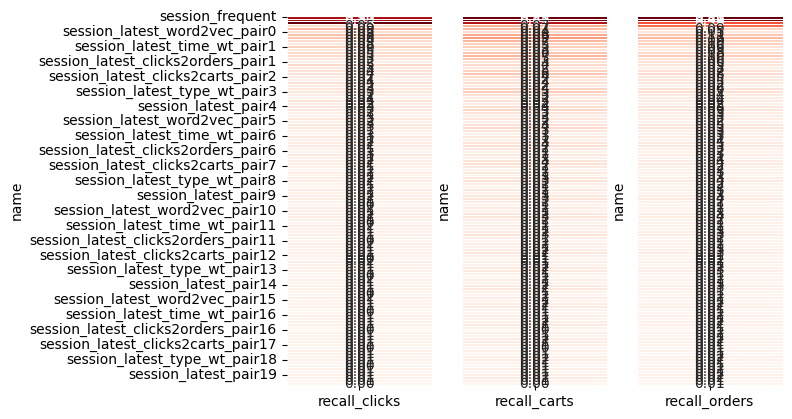

In [12]:
fig, axs = plt.subplots(1, 3)
sns.heatmap(results.set_index("name")[["recall_clicks"]].astype(float),
            annot=True, linewidths=.5, fmt="1.2f", cmap="Reds", cbar=False, ax=axs[0])
sns.heatmap(results.set_index("name")[["recall_carts"]].astype(float),
            annot=True, linewidths=.5, fmt="1.2f", cmap="Reds", cbar=False, ax=axs[1], yticklabels=False)
sns.heatmap(results.set_index("name")[["recall_orders"]].astype(float),
            annot=True, linewidths=.5, fmt="1.2f", cmap="Reds", cbar=False, ax=axs[2], yticklabels=False)
plt.savefig(cfg.output_dir + f'{cfg.exp_name}/candidate_strategy_recalls.png')

In [13]:
# 予測値を全て使えたときのrecall
valid_all = valid.drop_duplicates(subset= ["session", "aid"])
session_cnt_max = valid_all["session"].value_counts().max()
valid_all = valid_all.groupby("session")["aid"].apply(list).reset_index()

all_results = evaluate(valid_labels["clicks_labels"].tolist(),
                       valid_labels["carts_labels"].tolist(),
                       valid_labels["orders_labels"].tolist(),
                       valid_all["aid"].tolist(),
                       valid_all["aid"].tolist(),
                       valid_all["aid"].tolist(),
                       session_cnt_max)
logger.info("session_cnt_max")
logger.info(session_cnt_max)
logger.info("all_pred_results")
logger.info(all_results)

0:48:20.863738 	 session_cnt_max
0:48:20.864975 	 414
0:48:20.865742 	 all_pred_results
0:48:20.866383 	 {'num_clicks': 97259, 'hit_clicks': 61580, 'num_carts': 41457, 'hit_carts': 23580, 'num_orders': 19834, 'hit_orders': 14860, 'recall_clicks': '0.633', 'recall_carts': '0.569', 'recall_orders': '0.749', 'w_recall_clicks': '0.063', 'w_recall_carts': '0.171', 'w_recall_orders': '0.450', 'score': '0.683'}
